In [1]:
import pickle
import numpy as np
import pandas as pd

## MDS

In [2]:
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns; sns.set()

In [3]:
def mds(filename, figname):
  #read file
  df=pd.read_pickle(filename)   

  # create X for MDS
  X=np.array(df['embedding'].to_list())

  # get query_id for each answer
  query=np.unique(df['query_id'].to_list())

  embedding = MDS(n_components=2, eps=1e-6, max_iter=1000)
  X_transformed = embedding.fit_transform(X)

  colors = cm.rainbow(np.linspace(0, 1, len(query)))
  plt.figure(figsize=(10,9))
  for i in range(len(query)):
    plt.scatter(X_transformed[i*20:i*20+20,0], X_transformed[i*20:i*20+20,1], 
                c=np.repeat(colors[i][np.newaxis, :], 20, axis=0), label=i)
  plt.legend()
  plt.savefig(figname+'.png', format='png')
  plt.show()


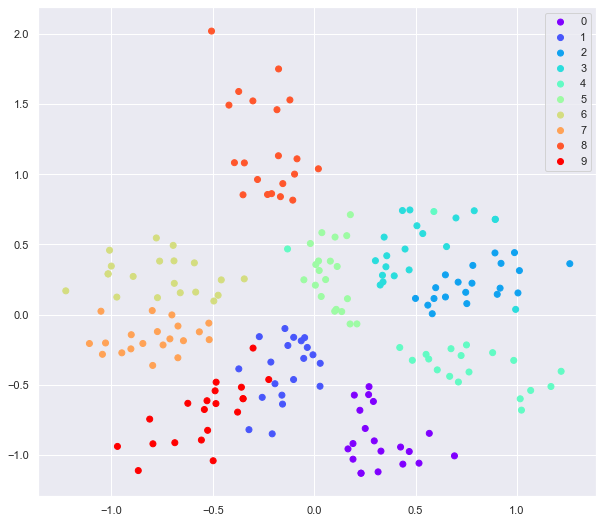

In [4]:
mds('result_w2v_0718.pkl', 'w2v_0718')

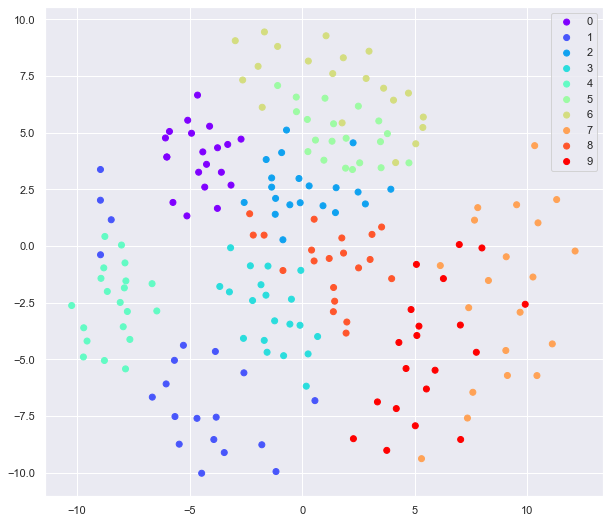

In [5]:
mds('result_bert_0722.pkl', 'result_bert_0722')

## Purity 

In [6]:
r1=pd.read_csv('/Users/ManluHe/Desktop/result_w2v_0718_score.csv',encoding='unicode_escape')
r2=pd.read_csv('/Users/ManluHe/Desktop/result_bert_0722_score.csv',encoding='unicode_escape')
r1=r1['embedding']
r2=r2['embedding']

In [7]:
#Generate data for evaluation
def generator(result):
    data=[]
    for i in range(len(result)):
        r=result[i]
        r=r.strip('[')
        r=r.strip(']')
        r=r.split(',')
        tmp=[]
        for x in range(100):
            tmp.append(float(r[x]))
        data.append(tmp)
    return data

In [8]:
#K-means clustering
from sklearn.cluster import KMeans

def KM(subtasks, data):
    model=KMeans(init='k-means++', n_clusters=subtasks, n_init=10)
    km=model.fit(data)
    lb=km.labels_
#     lb=model.predict(data)
#     print(lb)
    return lb

#Generate decision matrix
def d_matrix(cluster):
    c = np.repeat(cluster,200).reshape(10,20)
    return c

#Purity Eval
def purity(nclusters,docs,data):
    data=data.reshape(nclusters,docs)
    total=0
    for i in range(nclusters):
        cnt=[]
        for j in range(len(data)):
            x=data[j]
            y=d_matrix(i)[j]
            tmp=np.count_nonzero(np.in1d(x,y))
            cnt.append(tmp)
        total=total+np.max(cnt)
    pr = total/(nclusters*docs)
    return pr

In [9]:
#Word2Vec
data=generator(r1)
df=KM(10,data)
w2v_p=purity(10,20,df)
w2v_p

1.0

In [10]:
#BlueBERT
data1=generator(r2)
df1=KM(10,data1)
bert_p=purity(10,20,df1)
bert_p

0.815

## Score

In [11]:
import pandas as pd
df = pd.read_csv('/Users/ManluHe/Desktop/w2v.csv')
df1 = pd.read_csv('/Users/ManluHe/Desktop/bert.csv')

In [12]:
#Assign scores
import numpy as np

def get_score(subtasks,data):
    score_list=[]
    subtasks=subtasks
    for i in subtasks: 
        p1=data[i][:20]
        p2=data[i][20:]
        cnt=0
        for j in range(20):
            if p1[j]+p2[j+21] == 2.0:
                cnt=cnt+1
        score=cnt/20
        score_list.append(score)
    print('Subtask score',format(score_list))
    print('Average score',format(np.average(score_list)))

In [13]:
#Word2Vec
subtasks=['t1','t2','t3','t4','t5','t6','t7','t8','t9','t10']
get_score(subtasks,df)

Subtask score [0.3, 0.35, 0.75, 0.6, 0.6, 0.5, 0.6, 0.75, 0.65, 0.45]
Average score 0.555


In [14]:
#BlueBERT
get_score(subtasks,df1)

Subtask score [0.15, 0.0, 0.5, 0.05, 0.3, 0.25, 0.0, 0.05, 0.3, 0.05]
Average score 0.16500000000000004
